In [1]:
from keras.applications import VGG16
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
os.chdir("drive/MyDrive/Object-Localization")

In [15]:
# define the base path to the input dataset and then use it to derive
# the path to the images directory and annotation CSV file
BASE_PATH = ""
IMAGES_PATH = "images/face"
ANNOTS_PATH = "annotations/face.csv"

# initialize our initial learning rate, number of epochs to train
# for, and the batch size
INIT_LR = 1e-4
NUM_EPOCHS = 30
BATCH_SIZE = 16

In [16]:
# define the path to the base output directory
BASE_OUTPUT = ""
# define the path to the output serialized model, model training plot,
# and testing image filenames
MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "detector.h5"])
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])
TEST_FILENAMES = os.path.sep.join([BASE_OUTPUT, "test_images.txt"])


In [17]:
# load the contents of the CSV annotations file
print("[INFO] loading dataset...")
rows = open(ANNOTS_PATH).read().strip().split("\n")
# initialize the list of data (images), our target output predictions
# (bounding box coordinates), along with the filenames of the
# individual images
data = []
targets = []
filenames = []

[INFO] loading dataset...


In [18]:
# loop over the rows
i = 0
for row in rows:
    i += 1
    # break the row into the filename and bounding box coordinates
    row = row.split(",")
    (filename, startX, startY, endX, endY, _) = row
    imagePath = os.path.sep.join([IMAGES_PATH, filename])
    image = cv2.imread(imagePath)
    (h, w) = image.shape[:2]
    # scale the bounding box coordinates relative to the spatial
    # dimensions of the input image
    startX = float(startX) / w
    startY = float(startY) / h
    endX = float(endX) / w
    endY = float(endY) / h

    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    # update our list of data, targets, and filenames
    data.append(image)
    targets.append((startX, startY, endX, endY))
    filenames.append(filename)
    print(filename)


image_0001.jpg
image_0002.jpg
image_0003.jpg
image_0004.jpg
image_0005.jpg
image_0006.jpg
image_0007.jpg
image_0008.jpg
image_0009.jpg
image_0010.jpg
image_0011.jpg
image_0012.jpg
image_0013.jpg
image_0014.jpg
image_0015.jpg
image_0016.jpg
image_0017.jpg
image_0018.jpg
image_0019.jpg
image_0020.jpg
image_0021.jpg
image_0022.jpg
image_0023.jpg
image_0024.jpg
image_0025.jpg
image_0026.jpg
image_0027.jpg
image_0028.jpg
image_0029.jpg
image_0030.jpg
image_0031.jpg
image_0032.jpg
image_0033.jpg
image_0034.jpg
image_0035.jpg
image_0036.jpg
image_0037.jpg
image_0038.jpg
image_0039.jpg
image_0040.jpg
image_0041.jpg
image_0042.jpg
image_0043.jpg
image_0044.jpg
image_0045.jpg
image_0046.jpg
image_0047.jpg
image_0048.jpg
image_0049.jpg
image_0050.jpg
image_0051.jpg
image_0052.jpg
image_0053.jpg
image_0054.jpg
image_0055.jpg
image_0056.jpg
image_0057.jpg
image_0058.jpg
image_0059.jpg
image_0060.jpg
image_0061.jpg
image_0062.jpg
image_0063.jpg
image_0064.jpg
image_0065.jpg
image_0066.jpg
image_0067

In [19]:
# convert the data and targets to NumPy arrays, scaling the input
# pixel intensities from the range [0, 255] to [0, 1]
data = np.array(data, dtype="float32") / 255.0
targets = np.array(targets, dtype="float32")
# partition the data into training and testing splits using 90% of
# the data for training and the remaining 10% for testing
split = train_test_split(data, targets, filenames, test_size=0.10,
	random_state=42)
# unpack the data split
(trainImages, testImages) = split[:2]
(trainTargets, testTargets) = split[2:4]
(trainFilenames, testFilenames) = split[4:]


In [20]:
# load the VGG16 network, ensuring the head FC layers are left off
vgg = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
# freeze all VGG layers so they will *not* be updated during the
# training process
vgg.trainable = False
# flatten the max-pooling output of VGG
flatten = vgg.output
flatten = Flatten()(flatten)
# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid")(bboxHead)
# construct the model we will fine-tune for bounding box regression
model = Model(inputs=vgg.input, outputs=bboxHead)

In [21]:
# initialize the optimizer, compile the model, and show the model
# summary
opt = Adam(lr=INIT_LR)
model.compile(loss="mse", optimizer=opt)
print(model.summary())
# train the network for bounding box regression
print("[INFO] training bounding box regressor...")
H = model.fit(
	trainImages, trainTargets,
	validation_data=(testImages, testTargets),
	batch_size=BATCH_SIZE,
	epochs=NUM_EPOCHS,
	verbose=1)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

[INFO] saving object detector model...


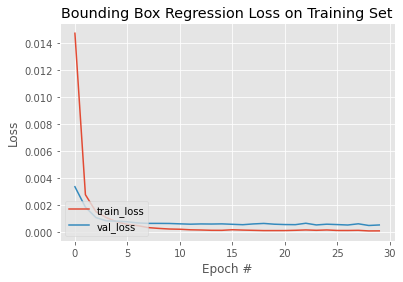

In [22]:
# serialize the model to disk
print("[INFO] saving object detector model...")
model.save(MODEL_PATH, save_format="h5")
# plot the model training history
N = NUM_EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Bounding Box Regression Loss on Training Set")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(PLOT_PATH)

66 33 163 211


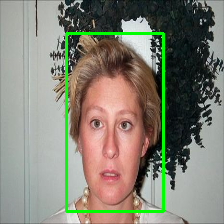

In [24]:
imagePath = "images/face/image_0274.jpg"
image = load_img(imagePath, target_size=(224, 224))
image = img_to_array(image) / 255.0
image = np.expand_dims(image, axis=0)
preds = model.predict(image)[0]
(startX, startY, endX, endY) = preds
#import imutils
from google.colab.patches import cv2_imshow
image = cv2.imread(imagePath)
image = cv2.resize(image, (224,224))
(h, w) = image.shape[:2]

startX = int(startX * w)
startY = int(startY * h)
endX = int(endX * w)
endY = int(endY * h)
print(startX, startY, endX, endY)
# draw the predicted bounding box on the image
image = cv2.rectangle(image, (startX, startY), (endX, endY),(0, 255, 0), 2)
# show the output image
cv2_imshow(image)